# Generate observed SED

Example for generating the *observed* spectrum for a parametric galaxy including
photometry. This example will:
- build a parametric galaxy (see make_sfzh and make_sed)
- calculate spectral luminosity density (see make_sed)
- calculate observed frame spectra (requires comsology and redshift)
- calculate observed frame fluxes

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from synthesizer.filters import FilterCollection
from synthesizer.grid import Grid
from synthesizer.parametric.sfzh import SFH, ZH, generate_sfzh
from synthesizer.galaxy.parametric import ParametricGalaxy as Galaxy
from synthesizer.plt import single, single_histxy, mlabel
from unyt import yr, Myr
from synthesizer.igm import Madau96, Inoue14
from astropy.cosmology import Planck18 as cosmo

In [4]:
grid_dir = '../../../tests/test_grid'
grid_name = 'test_grid'

grid = Grid(grid_name, grid_dir=grid_dir)

Define the parameters of the star formation and metal enrichment histories

In [6]:
sfh_p = {'duration': 10 * Myr}
Z_p = {'log10Z': -2.0}  # can also use linear metallicity e.g. {'Z': 0.01}
stellar_mass = 1E8

Define the functional form of the star formation and metal enrichment histories

In [9]:
sfh = SFH.Constant(sfh_p)  # constant star formation
Zh = ZH.deltaConstant(Z_p)  # constant metallicity

Get the 2D star formation and metal enrichment history for the given SPS grid. This is (age, Z).

In [12]:
sfzh = generate_sfzh(grid.log10ages, grid.metallicities, sfh, Zh, stellar_mass=stellar_mass)

Create a galaxy object

In [15]:
galaxy = Galaxy(sfzh)

Generate spectra using pacman model (complex)

In [17]:
sed = galaxy.get_pacman_spectra(grid, fesc=0.5, fesc_LyA=0.5, tauV=0.1)

Now calculate the observed frame spectra

In [20]:
z = 10.  # redshift
sed.get_fnu(cosmo, z, igm=Madau96())  # generate observed frame spectra

Define filters

In [23]:
filter_codes = [f'JWST/NIRCam.{f}' for f in ['F090W', 'F115W', 'F150W',
                                             'F200W', 'F277W', 'F356W', 'F444W']]  # define a list of filter codes
filter_codes += [f'JWST/MIRI.{f}' for f in ['F770W']]
fc = FilterCollection(filter_codes, new_lam=sed.obslam)

Measure broadband fluxes

In [27]:
fluxes = sed.get_broadband_fluxes(fc)

for filter, flux in fluxes.items():
    print(f'{filter}: {flux:.2f}')

JWST/NIRCam.F090W: 0.00 nJy
JWST/NIRCam.F115W: 0.00 nJy
JWST/NIRCam.F150W: 60.96 nJy
JWST/NIRCam.F200W: 52.88 nJy
JWST/NIRCam.F277W: 46.08 nJy
JWST/NIRCam.F356W: 38.26 nJy
JWST/NIRCam.F444W: 37.59 nJy
JWST/MIRI.F770W: 31.41 nJy


Make plot of observed including broadband fluxes (if filter collection object given)

total


AttributeError: 'str' object has no attribute 'pivwv'

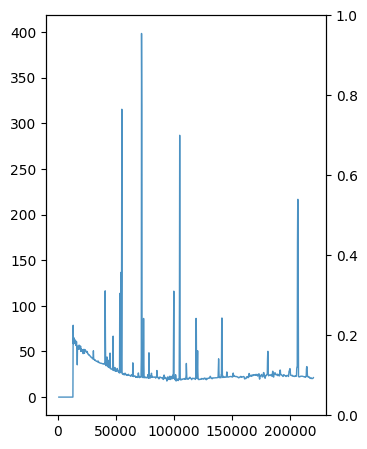

In [28]:
galaxy.plot_observed_spectra(cosmo, z, fc=fc, spectra_to_plot=['total'])